## Unsupervised Learning of Biomas data. 

--------------------------------
## **Context** 
-------------------------------

We study connection between carbon concentration in relation to the particle. We are trying to find 
dependancies and effect of various factos. Such as Temperature, wind, position, other products. 

Expectations: 
    min: the emerging clusters will correspond to the biomes as in Cabre et al 2016.
    max: by seeing how TK and ROY fall into different categories we might find the driving factors. 




----------------------------
## **Objective**
-----------------------------

Define driving factors

--------------------------
## **Data Description**
--------------------------
total carbon in the particles ranging from 0.5 to 50 um.
pico = 0.5-2 um, nano = 2-20 um, micro = 20-50 um
TK, ROY, Satellite data are downloaded for 2003-2007, resampled from 0.083(12 km) to 1 degree, using NN
Nitrate, Phosphate and silicate are from WOA

Winds and MLD are from EraInterim

- **Fe:** Iron from https://zenodo.org/record/6385044#.Y2hc-3bMKUk   Huang Y, Tagliabue A and Cassar N (2022)Data-driven modeling of dissolved iron in the global ocean.

- **TK_T:** Is calculated as in Kostadinov et al., 2016 
    All TK data is based on TK 2016, the LUTs were obtaing from Tiho in Feb 2020 before OS meeting in San Diego
- **ROY_T:** Total carbon calculated from size distributions (xi, k, particle numbers) provided by Shovonlal Sept 2019
    
    Both products use unified allometric coefficients described in Roy et al, 2013. 
- ** suffix _P, _N, _M:** denotes size group as noted above
    satellite gridded data: 
- **PAR:**  oceancolor SeaWiFS v 2020. 
- **PIC:**
- **Stram:**
- **Beh:** 
- **CHL:**
- **SST:**
- **MLD:**  WAs flipped? 
- **Wind, U10, V10, tccurl, lpcurl, vecurl:**, 
    
     PO4, Si, NO3, 
     
Coordinates:
- **Month_v:**  column shows the # of the month
- **Lon:**   Shows pixel number in a 1 degree coordinates, corresponds to Longitudes
- **Lat:**   Shows pixel number in a 1 degree coordinates, corresponds to Latitudes


In [1]:
# !pip install cartopy # Cartopy requires GEOS, Shapely and Pyshp
# !pip install cartopy
# import matplotlib.basemap as bmp 
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

^C


In [392]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# To compute distances
from scipy.spatial.distance import cdist, pdist

# To perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To import K-Medoids
from sklearn_extra.cluster import KMedoids

# To import DBSCAN and Gaussian Mixture
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# To perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# To suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [393]:
data = pd.read_csv("biomas_plus_yrdata.csv")

In [394]:
data.shape # Should be 180*360=64800, 27 features

(64800, 27)

In [395]:
data.sample(10, random_state = 1)

,TK_T,TK_P,TK_N,TK_M,ROY_T,ROY_P,ROY_N,ROY_M,PAR,MLD,SST,Wind,U10,V10,tccurl,lpcurl,vecurl,PIC,Stram,Beh,CHL,PO4,Si,NO3,Fe,Lon,Lat
64781,70.256829,24.614824,31.918186,13.723819,12.223079,3.820973,5.427610,2.974496,24.559673,60.545979,-0.994271,8.230861,0.272129,3.904691,-0.001080,-0.000716,-0.000939,0.000235,88.916573,40.600944,0.396568,1.934912,60.849177,28.007338,NaN,360,162
18911,144.687133,17.955327,70.163307,56.568499,28.459422,10.896481,9.745344,7.817598,14.609109,19.338345,0.946483,3.524572,0.714476,-2.004377,-0.011499,-0.012910,-0.011433,0.000402,132.379907,45.851639,0.925024,NaN,NaN,NaN,NaN,106,12
11788,33.939457,18.366242,12.961850,2.611365,8.474787,4.600906,3.067124,0.806757,50.178966,NaN,25.206916,5.730063,-3.826934,3.783601,-0.002260,-0.002439,-0.002256,0.000049,59.430739,14.053112,0.202953,0.647842,4.455902,4.538625,0.115378,66,89
10477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.012898,163.668714,9.218646,2.513253,0.047936,0.855935,-0.000523,-0.000634,-0.000424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,38
12075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.856998,10.725575,4.500333,3.993577,0.570503,-1.367255,-0.002891,-0.003349,-0.003229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,16
43522,25.884083,16.157239,8.202708,1.524136,7.533201,5.610750,1.640496,0.281956,19.922065,122.704730,2.259333,12.084206,9.353098,-1.136161,-0.001577,-0.001912,-0.001562,0.000166,53.434239,19.034342,0.150066,1.649108,14.826749,24.658216,NaN,242,143
38024,100.709767,28.731529,48.186755,23.791482,30.401306,5.602586,14.126873,10.671847,31.153832,19.101641,14.798916,5.528864,0.042091,-0.890395,-0.004166,-0.004138,-0.003502,0.000583,229.024908,NaN,1.172683,0.222251,12.095047,0.825018,NaN,212,45
51932,49.377641,29.360971,16.726596,3.290074,14.073998,3.384230,5.612197,5.077572,43.660432,24.138597,29.266937,4.262556,-0.651365,0.644524,-0.001409,-0.001488,-0.001491,0.001276,126.294452,78.215984,0.442062,NaN,NaN,NaN,NaN,289,93
63428,10.885837,9.219956,1.580329,0.085553,2.662114,2.015847,0.539817,0.106449,45.540032,NaN,27.110749,6.400653,-4.836927,-0.570494,-0.003612,-0.003299,-0.003173,0.000061,24.561572,9.879537,0.049944,0.080481,1.135889,0.137808,0.230555,353,69
49876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.542712,NaN,4.514063,-0.111191,-0.343139,-0.004506,-0.004431,-0.004060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278,17


Observations

The data has 777600 rows and 28 columns. 
The rows are consistent with 180 x 360 x 12 

In [396]:
# Copying the data to another variable to avoid any changes to original data
df = data.copy()

In [397]:
# Checking datatypes and number of non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64800 entries, 0 to 64799
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TK_T    38579 non-null  float64
 1   TK_P    38579 non-null  float64
 2   TK_N    38579 non-null  float64
 3   TK_M    38579 non-null  float64
 4   ROY_T   38914 non-null  float64
 5   ROY_P   38914 non-null  float64
 6   ROY_N   38914 non-null  float64
 7   ROY_M   38914 non-null  float64
 8   PAR     40606 non-null  float64
 9   MLD     47273 non-null  float64
 10  SST     43898 non-null  float64
 11  Wind    64800 non-null  float64
 12  U10     64800 non-null  float64
 13  V10     64800 non-null  float64
 14  tccurl  64800 non-null  float64
 15  lpcurl  64800 non-null  float64
 16  vecurl  64800 non-null  float64
 17  PIC     38666 non-null  float64
 18  Stram   38928 non-null  float64
 19  Beh     37695 non-null  float64
 20  CHL     38732 non-null  float64
 21  PO4     41088 non-null  float64
 22

In [398]:
# Checking for duplicate values
df.duplicated().sum()

0

In [399]:
# Checking for missing values
df.isnull().sum()

TK_T      26221
TK_P      26221
TK_N      26221
TK_M      26221
ROY_T     25886
ROY_P     25886
ROY_N     25886
ROY_M     25886
PAR       24194
MLD       17527
SST       20902
Wind          0
U10           0
V10           0
tccurl        0
lpcurl        0
vecurl        0
PIC       26134
Stram     25872
Beh       27105
CHL       26068
PO4       23712
Si        23712
NO3       23712
Fe        40420
Lon           0
Lat           0
dtype: int64

TK data for each size group has the same missing values. 
ROY data also has the same nans in each size group
This comes from 1. available reflectancies (in the case of TK) or satellite absorption+chl data in case of ROY.
ROY has more data. 
ROY and TK products have about 50% of a full gridded product.
This is expected because wind or coordicate products do not have NaNs over continents and in the "dark" winter areas in respective hemispheres. 

The situation is similar for Behrenfeld, Stramski, Chlorophyll and PIC data that is derived from satellite data over the ocean. 

PAR, MLD and SST have mich better coverage, also showing missing values over the continents. 

Wind and wind curl parameters present a full stack, including data over continents. 

PO4, Si and NO3 are from World Ocean Atlas and cover the ocean except for continents

Month, Lon and Lat repesent coordicante and have no missing values. 
There are no duplicates 

All the other columns in the data are numeric in nature.
However, I want to change Months to categorical. 


## **Exploratory Data Analysis**

In [400]:
# over-the-land data makes no sense we drop the rows with NaNs. 
df  = df.dropna()
df.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
TK_T,19406.0,36.226974,23.859352,8.448609,18.110253,29.904054,46.985585,282.470679
TK_P,19406.0,16.054374,3.908125,7.646307,12.838091,16.545852,19.144948,34.956965
TK_N,19406.0,14.468209,12.952205,0.579869,4.464936,10.559308,20.471838,136.637579
TK_M,19406.0,5.704391,8.239878,0.006650,0.606154,2.371316,7.221871,111.397542
ROY_T,19406.0,8.531718,5.106905,1.474457,5.081142,7.696927,10.594410,128.923324
ROY_P,19406.0,4.783357,1.808814,0.430565,3.347183,4.830463,6.066231,28.000659
ROY_N,19406.0,2.674448,2.234068,0.239911,1.184950,2.024632,3.396479,34.055621
ROY_M,19406.0,1.073913,1.938762,0.021735,0.272816,0.523562,1.074587,103.110255
PAR,19406.0,33.196139,11.312142,7.834886,22.226456,34.560049,43.593216,53.264933
MLD,19406.0,45.194922,33.966314,10.085993,23.901550,34.667044,54.276628,475.319376


**Observations:**

- without NaNs the data is way smaller.
- MLD has the biggerst range. 
- Stramski has very big values. very likely - outliers
- TK,  Stramski seem to be in the same range. 
- ROY and Behrenfeld are smaller (closer?)
- PIC and curls are tiny. The data will need standartization. 

Q: How am I going to make the test data? 

Univariate Analysis

In [328]:
# Function to plot a boxplot and a histogram along the same scale


def histogram_boxplot(data, feature, figsize = (8, 5), kde = False, bins = None):
    
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12, 7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,  # Number of rows of the subplot grid= 2
        sharex = True,  # X-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,
    )  # Creating the 2 subplots
    sns.boxplot(
        data = data, x = feature, ax = ax_box2, showmeans = True, color = "violet"
    )  # Boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins, palette = "winter"
    ) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color = "green", linestyle = "--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color = "black", linestyle = "-"
    )  # Add median to the histogram

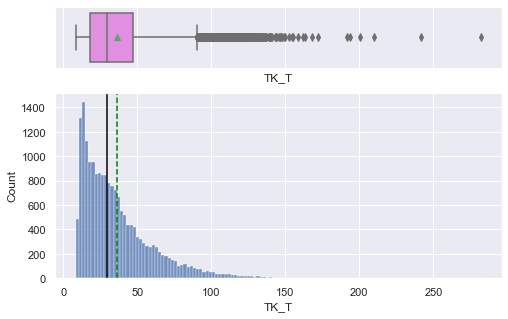

In [14]:
histogram_boxplot(df, 'TK_T')

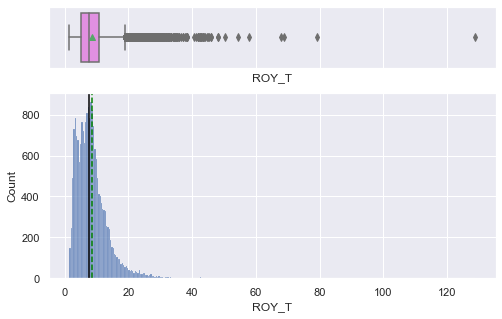

In [15]:
histogram_boxplot(df, 'ROY_T')

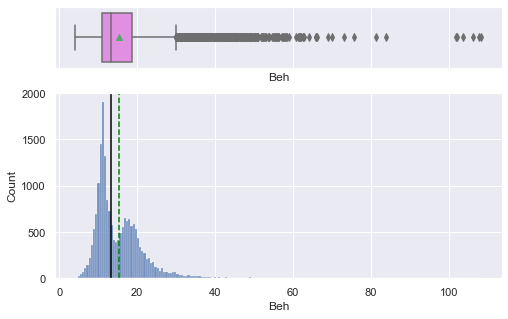

In [16]:
histogram_boxplot(df, 'Beh')

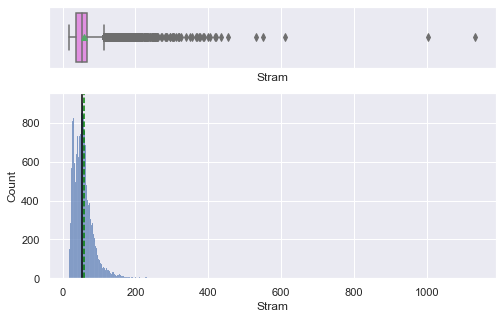

In [17]:
histogram_boxplot(df, 'Stram')

Here we see very clearly that Stramski data has very big outliers

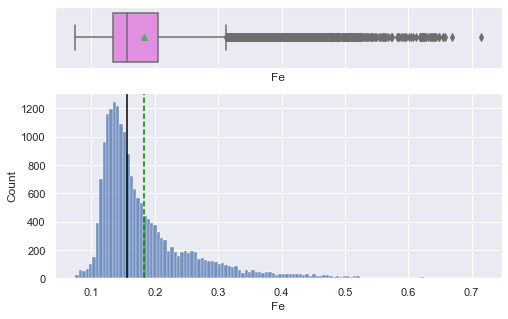

In [18]:
histogram_boxplot(df, 'Fe')

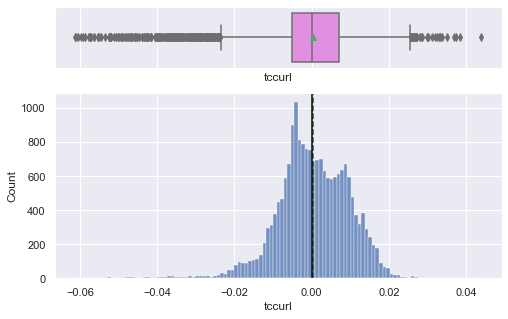

In [23]:
histogram_boxplot(df, 'tccurl')

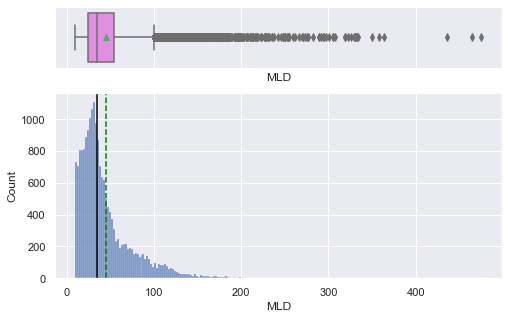

In [329]:
histogram_boxplot(df, 'MLD')

In [18]:
# # Function to create labeled barplots

# def labeled_barplot(data, feature, perc = False, n = None):
#     """
#     Barplot with percentage at the top

#     data: dataframe
#     feature: dataframe column
#     perc: whether to display percentages instead of count (default is False)
#     n: displays the top n category levels (default is None, i.e., display all levels)
#     """

#     total = len(data[feature])  # Length of the column
#     count = data[feature].nunique()
#     if n is None:
#         plt.figure(figsize = (count + 1, 5))
#     else:
#         plt.figure(figsize = (n + 1, 5))

#     plt.xticks(rotation = 90, fontsize = 15)
#     ax = sns.countplot(
#         data = data,
#         x = feature,
#         palette = "Paired",
#         order = data[feature].value_counts().index[:n].sort_values(),
#     )

#     for p in ax.patches:
#         if perc == True:
#             label = "{:.1f}%".format(
#                 100 * p.get_height() / total
#             )  # Percentage of each class of the category
#         else:
#             label = p.get_height()  # Count of each level of the category

#         x = p.get_x() + p.get_width() / 2  # Width of the plot
#         y = p.get_height()  # Height of the plot

#         ax.annotate(
#             label,
#             (x, y),
#             ha = "center",
#             va = "center",
#             size = 12,
#             xytext = (0, 5),
#             textcoords = "offset points",
#         )  # Annotate the percentage

#     plt.show()  # Show the plot

In [20]:
# labeled_barplot(df, 'Month_v')
# makes no sense after replacing months with dummies

KeyError: 'Month_v'

Bivariate Analysis
## We check correlations with other parameters
and drop the tccurl column

In [331]:
# cols_list

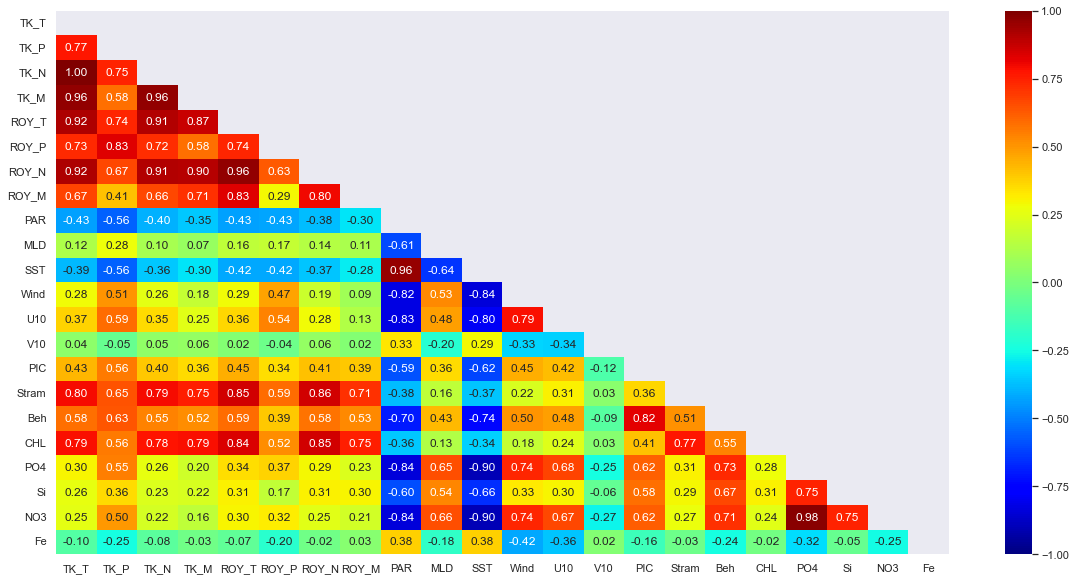

In [403]:
df_in = df.copy() 
df_in = df_in.drop(['tccurl', 'lpcurl','vecurl'],axis=1)

# Correlation check
cols_list = df_in.select_dtypes(include = np.number).columns.tolist()

plt.figure(figsize = (20, 10))
# Generate a mask for the upper triangle
corr = df[cols_list[:-2]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    df_in[cols_list[:-2]].corr(),mask=mask, annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "jet"
)
# plt.savefig("corr_matrix_tr_12mon.png", facecolor='white')
plt.show()
# plt.savefig("corr_matrix_12mon.png")

**Observations: for seasonality  = average for wach month 12 months**

- biomass products are nicely correlated 
- Chl positive with biomass
- PIC is positive though smaller than biomass products
- PAR and SST are negative
- Iron is negative?? This is surprizing
- Latitude is also negative?? Also surprizing 

- Wind, esp U is positive with Lat, NO3, PO4 and even Si


In [333]:
# taking forever. run at night

# sns.pairplot(df[cols_list[:-14]],  corner = True)
# plt.legend( fontsize=25)
# plt.savefig("corr_scatters_hue_12mon.png", facecolor = 'white')

# plt.show()

Outlier Check

{'whiskers': [<matplotlib.lines.Line2D at 0x171ae613bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x171ae612a40>,
 'boxes': [<matplotlib.lines.Line2D at 0x171ae610160>],
 'medians': [<matplotlib.lines.Line2D at 0x171ae6119c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x171ae611960>],
 'means': []}

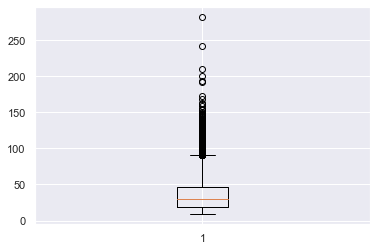

In [334]:
filtered_data = df_in['TK_T'][~np.isnan(df_in['TK_T'])]
plt.boxplot(filtered_data)
# plt.boxplot(df_in['TK_T'])
# fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
# ax1.boxplot(df_in['TK_T'])
# plt.show()
# plt.show()
# plt. plot(df_in['TK_T'])

In [347]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19406 entries, 212 to 64420
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TK_T    19406 non-null  float64
 1   TK_P    19406 non-null  float64
 2   TK_N    19406 non-null  float64
 3   TK_M    19406 non-null  float64
 4   ROY_T   19406 non-null  float64
 5   ROY_P   19406 non-null  float64
 6   ROY_N   19406 non-null  float64
 7   ROY_M   19406 non-null  float64
 8   PAR     19406 non-null  float64
 9   MLD     19406 non-null  float64
 10  SST     19406 non-null  float64
 11  Wind    19406 non-null  float64
 12  U10     19406 non-null  float64
 13  V10     19406 non-null  float64
 14  PIC     19406 non-null  float64
 15  Stram   19406 non-null  float64
 16  Beh     19406 non-null  float64
 17  CHL     19406 non-null  float64
 18  PO4     19406 non-null  float64
 19  Si      19406 non-null  float64
 20  NO3     19406 non-null  float64
 21  Fe      19406 non-null  float64
 

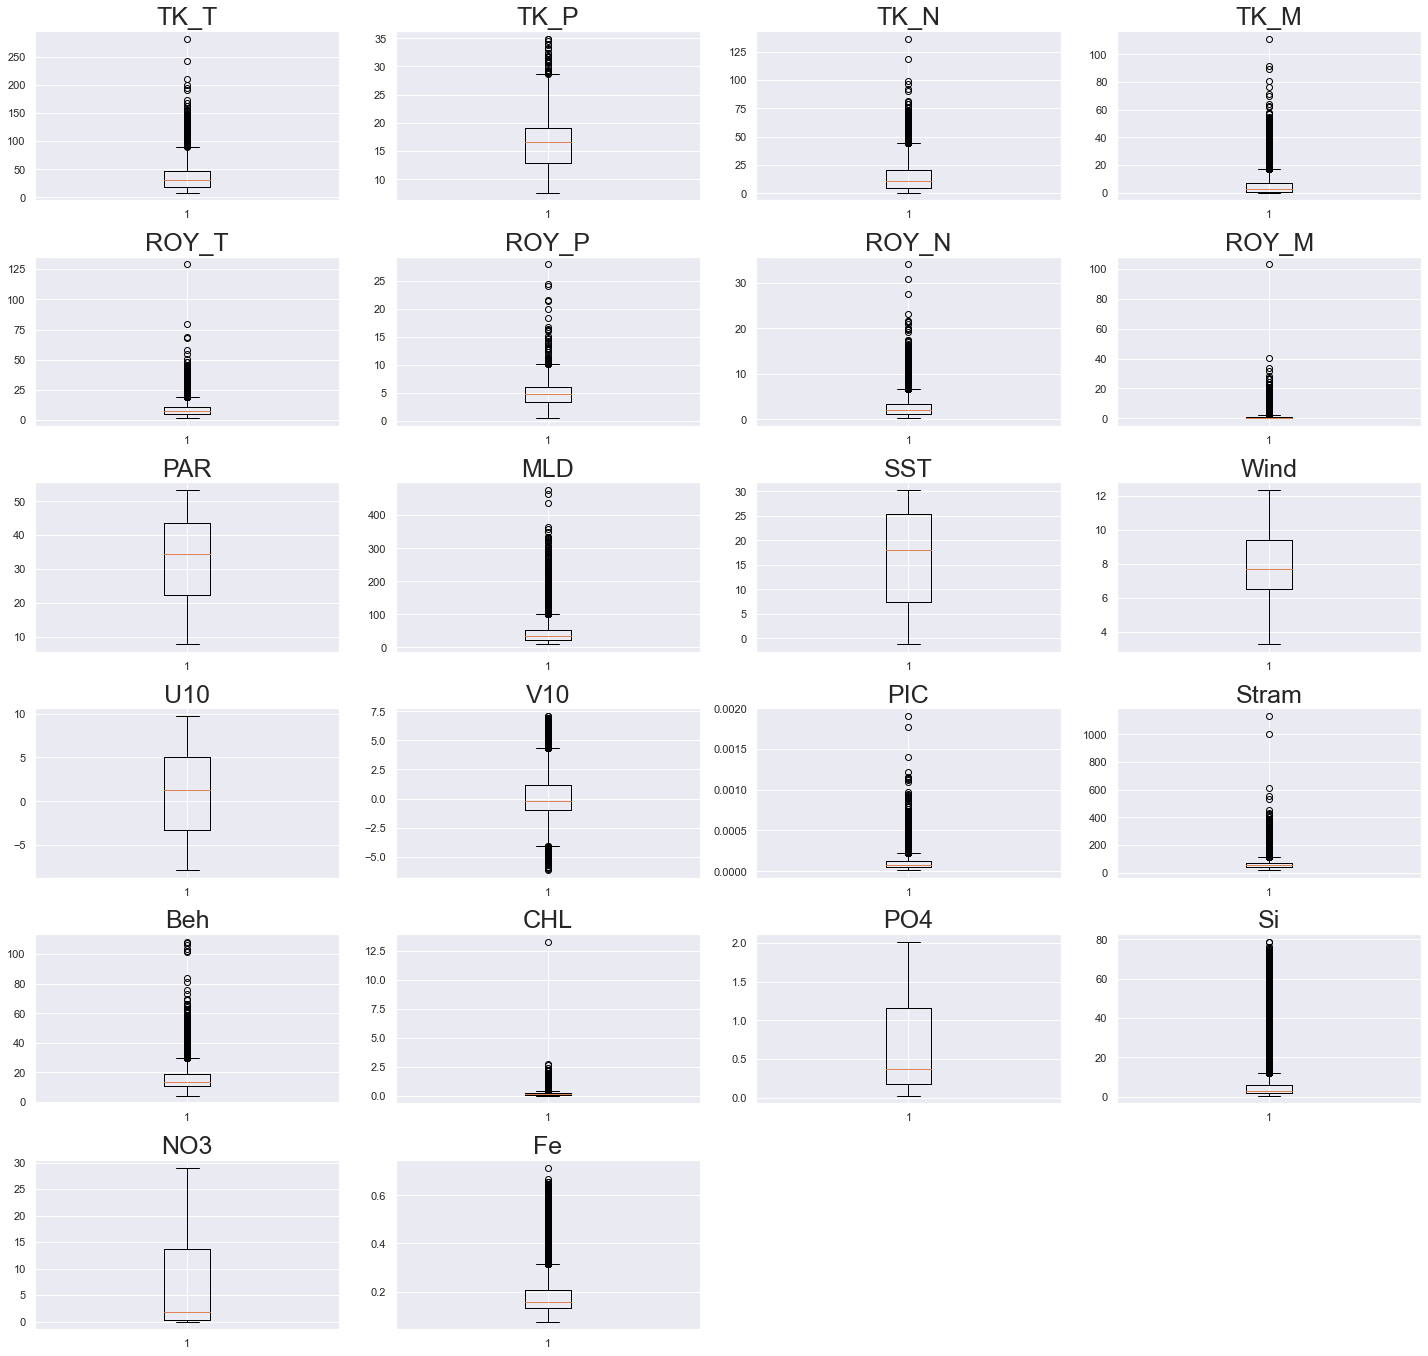

In [335]:
# ['TK_T', 'TK_P', 'TK_N', 'TK_M', 'ROY_T', 'ROY_P', 'ROY_N', 'ROY_M', 'PAR', 'MLD', 
#  'SST', 'Wind', 'U10', 'V10', 'tccurl', 'lpcurl', 'vecurl', 'PIC', 'Stram', 'Beh', 
#  'CHL', 'PO4', 'Si', 'NO3', 'Fe', 'Lon', 'Lat']

plt.figure(figsize = (20, 25))

# numeric_columns = df.select_dtypes(include = np.number).columns.tolist()

for i, variable in enumerate(cols_list[:-2]):
        
    plt.subplot(8, 4, i + 1)
    
    filtered_data = df_in[variable][~np.isnan(df_in[variable])]
    
    plt.boxplot(filtered_data)
    
    plt.tight_layout()
    
    plt.title(variable, fontsize=25)

# plt.savefig("outliers_mon.png", facecolor = 'white')
plt.show()

The data is either very scewed, or there are too many outliers.
The ways of dealing: 
1. Drop remove some values. (maybe not rows) 
2. Log transform. Advantages: Accepted in the communuty and reduces the effect. 
                  Disadvantages: harder to analyse. Does not make sence in some cases. 

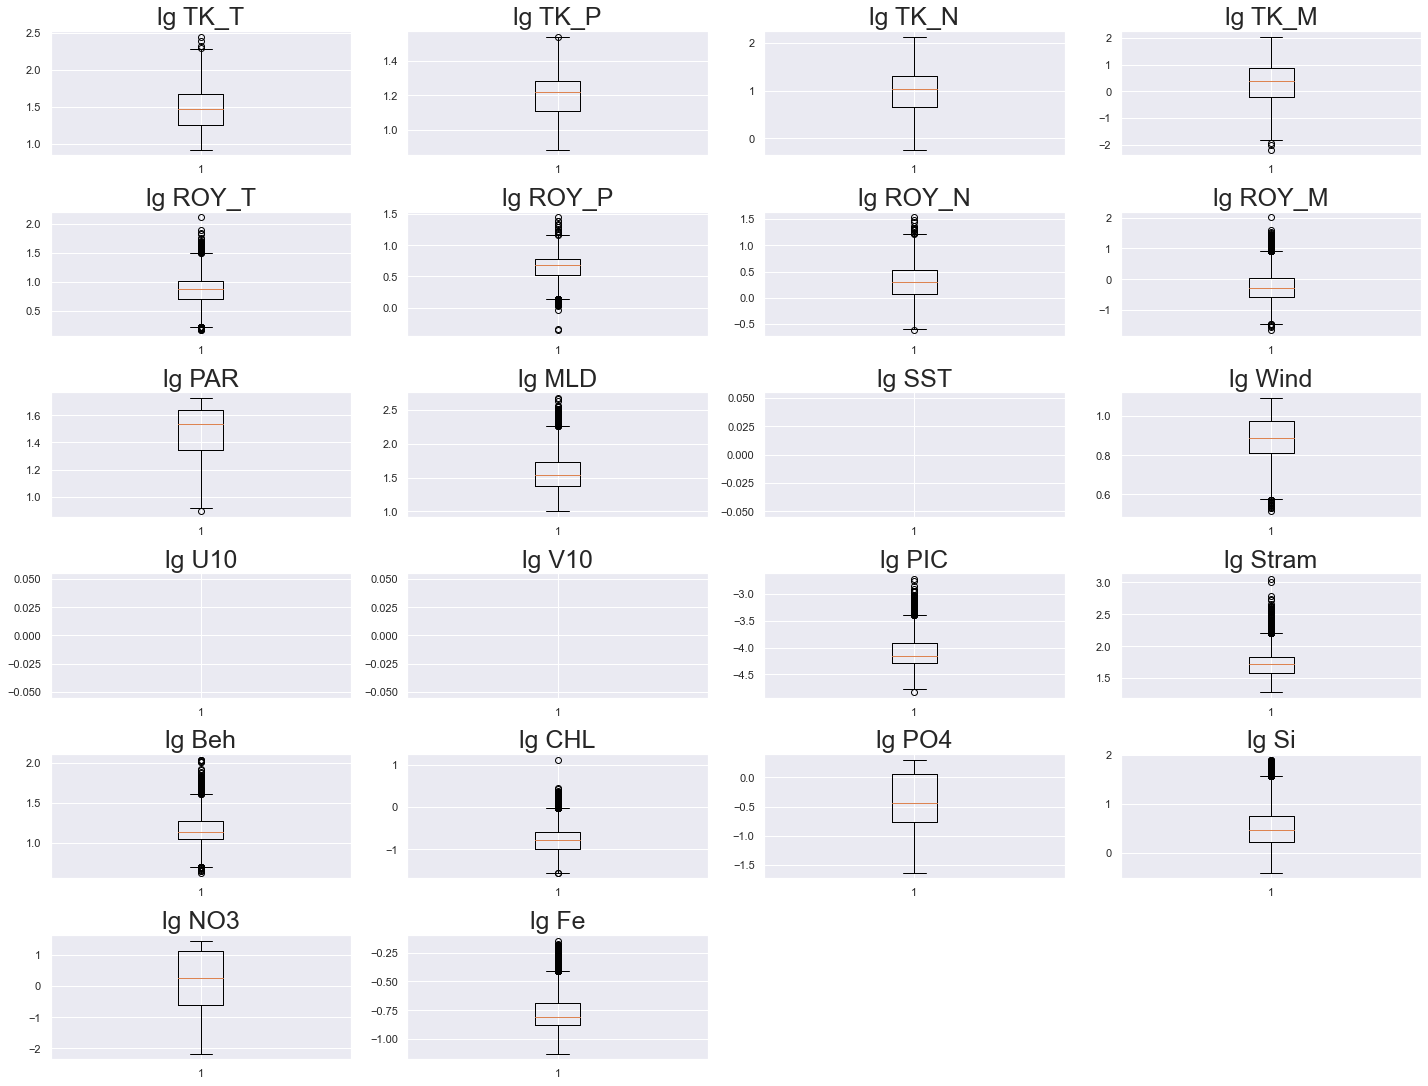

In [336]:
# lets take a look at the same plots with Log transform
plt.figure(figsize = (20, 20))

# numeric_columns = df.select_dtypes(include = np.number).columns.tolist()

for i, variable in enumerate(cols_list[:-2]):
    
    plt.subplot(8, 4, i + 1)
    
    filtered_data = df_in[variable][~np.isnan(df_in[variable])]
    
    plt.boxplot(np.log10(filtered_data), whis = 1.5)
    
    plt.tight_layout()
    
    plt.title('lg ' + variable, fontsize=25)

# plt.savefig("log_outliers_mon.png", facecolor = 'white')
plt.show()

- **Tukey’s rule to detect outliers:**. It is also known as the IQR rule. First, we will calculate the Interquartile Range of the data (IQR = Q3 — Q1). Later, we will determine our outlier boundaries with IQR.
- **Winsorize Method:** the cut off boundaries are preset. normally we use 0.01 and 0.99.
- **Logtranform:**  Log transformation is commonly used for machine learning algorithms. Be careful, it changes our values but removes outliers. It makes our model normal and the machine learning algorithm likes normal distribution data. There are some methods and features in machine learning algorithms such as scaling and normalization. We will talk about these terms in our next stories.
Should **play with the log base** 10? e?

- Log10 and ln looks very similar.
- Doesn’t make sense for negative values
- I would stick to log10.  For biomass. Even MLD looks better in Log
- PIC, Stramki and Behrenfeld, looks like CHL,  SI,  Fe  
**but it was shown that it makes little difference for correlations*

In [66]:
# # print(cols_list[:-2])
# cols_toLog = ['TK_T', 'TK_P', 'TK_N', 'TK_M', 'ROY_T', 'ROY_P', 'ROY_N', 'ROY_M', 'PAR', 'MLD', 
#  'SST', 'PIC', 'Stram', 'Beh', 'CHL',  'Si', 'Fe']
# for col in cols_toLog:
#     df[col] = np.log10(df[col])
    
# df.tail()

In [348]:
# Copying the data to another variable to avoid any changes to already preprocessed data
df_clean = df_in.copy()

In [349]:
# Remove outliers that are way too far/big/small

for ccol in cols_list[:-2]:
    max_cond = df_clean[ccol].quantile(0.99)
    min_cond = df_clean[ccol].quantile(0.01)
# print(max_cond)
    df_clean.loc[df_clean[ccol] > max_cond, ccol] = np.nan
    df_clean.loc[df_clean[ccol] < min_cond, ccol] = np.nan 
# df_clean.dropna()  
df_clean.dropna(axis='rows', how = 'any')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19406 entries, 212 to 64420
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TK_T    19016 non-null  float64
 1   TK_P    19016 non-null  float64
 2   TK_N    19016 non-null  float64
 3   TK_M    19016 non-null  float64
 4   ROY_T   19016 non-null  float64
 5   ROY_P   19016 non-null  float64
 6   ROY_N   19016 non-null  float64
 7   ROY_M   19016 non-null  float64
 8   PAR     19016 non-null  float64
 9   MLD     19016 non-null  float64
 10  SST     19016 non-null  float64
 11  Wind    19016 non-null  float64
 12  U10     19016 non-null  float64
 13  V10     19016 non-null  float64
 14  PIC     19016 non-null  float64
 15  Stram   19016 non-null  float64
 16  Beh     19016 non-null  float64
 17  CHL     19016 non-null  float64
 18  PO4     19016 non-null  float64
 19  Si      19016 non-null  float64
 20  NO3     19016 non-null  float64
 21  Fe      19016 non-null  float64
 

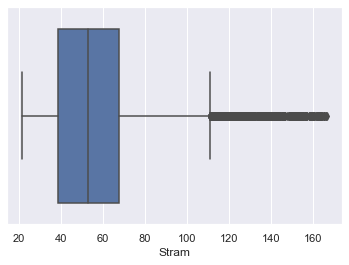

In [350]:
sns.boxplot(df_clean['Stram'])
# plt.plot(df_clean['Stram'])
plt.show()

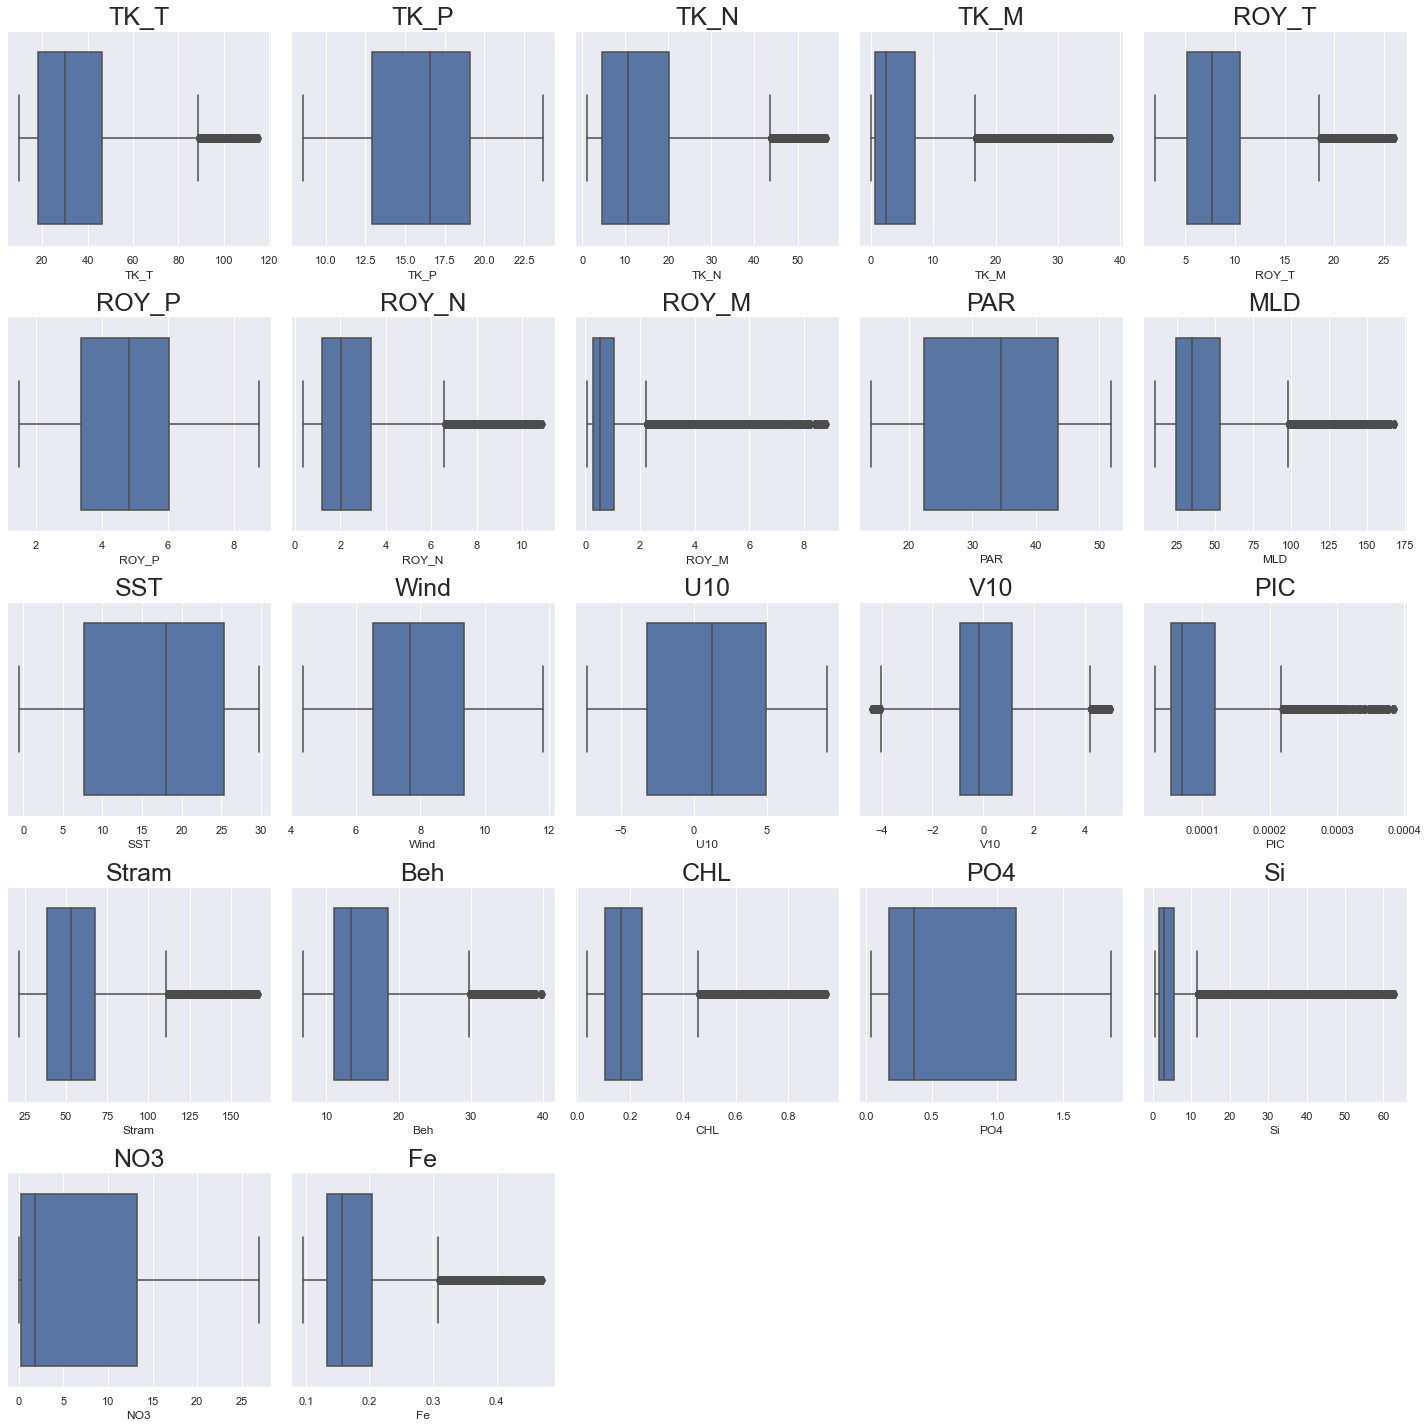

In [351]:
plt.figure(figsize = (20, 20))

# numeric_columns = df.select_dtypes(include = np.number).columns.tolist()

for i, variable in enumerate(cols_list[:-2]):
    
    plt.subplot(5, 5, i + 1)
    
    sns.boxplot(df_clean[variable], whis = 1.5)
    
    plt.tight_layout()
    
    plt.title(variable, fontsize=25)
# 
plt.savefig("biomas_distrib.png", facecolor = 'white')
plt.show()

In [354]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19406 entries, 212 to 64420
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TK_T    19016 non-null  float64
 1   TK_P    19016 non-null  float64
 2   TK_N    19016 non-null  float64
 3   TK_M    19016 non-null  float64
 4   ROY_T   19016 non-null  float64
 5   ROY_P   19016 non-null  float64
 6   ROY_N   19016 non-null  float64
 7   ROY_M   19016 non-null  float64
 8   PAR     19016 non-null  float64
 9   MLD     19016 non-null  float64
 10  SST     19016 non-null  float64
 11  Wind    19016 non-null  float64
 12  U10     19016 non-null  float64
 13  V10     19016 non-null  float64
 14  PIC     19016 non-null  float64
 15  Stram   19016 non-null  float64
 16  Beh     19016 non-null  float64
 17  CHL     19016 non-null  float64
 18  PO4     19016 non-null  float64
 19  Si      19016 non-null  float64
 20  NO3     19016 non-null  float64
 21  Fe      19016 non-null  float64
 

In [363]:
# make sure there are no NaNs for PCA. However, there are methods that aren't sensitive to this

df_PCA = df_clean.copy()
df_PCA = df_PCA.dropna(axis = 'rows', how = 'any')
df_PCA.info()
df_PCA.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15020 entries, 213 to 64412
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TK_T    15020 non-null  float64
 1   TK_P    15020 non-null  float64
 2   TK_N    15020 non-null  float64
 3   TK_M    15020 non-null  float64
 4   ROY_T   15020 non-null  float64
 5   ROY_P   15020 non-null  float64
 6   ROY_N   15020 non-null  float64
 7   ROY_M   15020 non-null  float64
 8   PAR     15020 non-null  float64
 9   MLD     15020 non-null  float64
 10  SST     15020 non-null  float64
 11  Wind    15020 non-null  float64
 12  U10     15020 non-null  float64
 13  V10     15020 non-null  float64
 14  PIC     15020 non-null  float64
 15  Stram   15020 non-null  float64
 16  Beh     15020 non-null  float64
 17  CHL     15020 non-null  float64
 18  PO4     15020 non-null  float64
 19  Si      15020 non-null  float64
 20  NO3     15020 non-null  float64
 21  Fe      15020 non-null  float64
 

,TK_T,TK_P,TK_N,TK_M,ROY_T,ROY_P,ROY_N,ROY_M,PAR,MLD,SST,Wind,U10,V10,PIC,Stram,Beh,CHL,PO4,Si,NO3,Fe,Lon,Lat
213,93.415760,20.627510,46.369711,26.418540,22.491640,7.373726,9.503942,5.613971,17.339264,133.519939,5.309917,8.533042,-0.373526,-0.661761,0.000174,130.818425,24.514392,0.707617,1.688715,36.371675,17.706923,0.162270,2,34
214,88.135992,19.890480,43.033768,25.211744,18.900750,6.043712,8.375642,4.481396,17.757064,149.333065,5.554833,8.609679,0.014558,-0.446003,0.000087,121.186943,24.302691,0.541803,1.708275,37.560619,18.269347,0.158520,2,35
215,81.319665,19.697681,39.407151,22.214832,16.094757,5.669616,6.078402,4.346739,18.309698,132.659894,5.372333,8.706004,0.301060,-0.240905,0.000140,111.240647,23.730567,0.520367,1.701497,38.029529,18.454001,0.167056,2,36
216,105.019851,20.559956,52.144119,32.315775,19.964172,6.566538,9.001948,4.395686,18.499598,33.754839,5.500403,8.775414,0.794858,-0.204257,0.000092,134.763240,24.310856,0.596771,1.664337,37.360642,18.372599,0.180131,2,37
219,105.001463,21.329952,50.595217,33.076293,21.075070,6.333699,9.033775,5.707596,19.916565,31.758396,6.322917,8.912842,2.171124,0.362151,0.000121,129.218391,21.624637,0.708467,1.455113,27.758743,16.341985,0.204469,2,40


the data looks more "normal'

**DROP Lat and Lon**

**Scaling**
Let's scale the data before we proceed with clustering.
After scalling, PIC still has very low values. We ended up having no cluster associated with PIC.
Jan 2023 I am trying to Normalize the data and try it all again

In [364]:
# Scaling the data before clustering

# cols_list = df_clean.select_dtypes(include = np.number).columns.tolist()
# define Standartization scaler
# scaler = StandardScaler()
# define min max scaler - Normalization 0-1
scaler = MinMaxScaler()

subset = df_PCA[cols_list[:-2]].copy()
# subset = subset.drop(['Lat', 'Lon'], axis=1)
subset_scaled = scaler.fit_transform(subset)
# dsc = pd.DataFrame(subset_scaled, columns = ['Column_A','Column_B','Column_C'])subset_scaled

In [365]:
# Creating a dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns = subset.columns)
subset_scaled_df.head()

,TK_T,TK_P,TK_N,TK_M,ROY_T,ROY_P,ROY_N,ROY_M,PAR,MLD,SST,Wind,U10,V10,PIC,Stram,Beh,CHL,PO4,Si,NO3,Fe
0,0.791782,0.798786,0.814454,0.686318,0.873521,0.809792,0.870136,0.634319,0.084953,0.780610,0.192231,0.560328,0.422088,0.397157,0.407420,0.755163,0.535504,0.750682,0.906639,0.574211,0.658033,0.176361
1,0.741728,0.749861,0.754379,0.654921,0.720555,0.626358,0.762686,0.504801,0.096058,0.881156,0.200349,0.570642,0.445762,0.420009,0.159694,0.688466,0.529114,0.564981,0.917407,0.593327,0.678981,0.166396
2,0.677106,0.737062,0.689070,0.576949,0.601025,0.574763,0.543916,0.489402,0.110748,0.775142,0.194300,0.583606,0.463239,0.441732,0.312406,0.619589,0.511845,0.540974,0.913675,0.600866,0.685858,0.189081
3,0.901793,0.794302,0.918441,0.839748,0.765855,0.698465,0.822330,0.495000,0.115796,0.146267,0.198545,0.592947,0.493362,0.445613,0.175127,0.782481,0.529361,0.626542,0.893219,0.590111,0.682827,0.223829
4,0.901619,0.845416,0.890548,0.859535,0.813178,0.666353,0.825361,0.645025,0.153461,0.133573,0.225810,0.611442,0.577318,0.505604,0.258969,0.744083,0.448278,0.751635,0.778040,0.435734,0.607194,0.288507


**DEFINE THE NUMBER OF PCA COMPONENTS**

**Applying PCA to the full dataset** Alternative: t-SNE

In [366]:
# Importing PCA
from sklearn.decomposition import PCA

# Defining the number of principal components to generate
# n = subset.shape[1]                # Storing the number of variables in the data(all features as components)
n =10 # see above PCA

pca = PCA(n_components = n, random_state = 1)                       # Storing PCA function with n components

data_pca = pd.DataFrame(pca.fit_transform(subset_scaled_df))          # Applying PCA on scaled data

# The percentage of variance explained by each principal component is stored
exp_var = (pca.explained_variance_ratio_)  

In [367]:
data_pca

,0,1,2,3,4,5,6,7,8,9
0,1.487120,0.999379,0.893268,0.257199,0.174963,-0.237281,0.411273,-0.098981,0.011557,-0.011960
1,1.358969,0.716484,0.867867,0.260904,0.222838,-0.167778,0.504270,-0.082857,-0.118737,-0.027604
2,1.280417,0.520907,0.810007,0.193434,0.170509,-0.151701,0.373160,-0.046314,0.004724,-0.009482
3,1.357480,1.097159,0.800109,0.238946,0.202243,-0.248896,-0.148140,-0.115567,-0.204842,0.180028
4,1.286864,1.222809,0.713399,0.283864,0.231157,-0.141243,-0.206916,-0.117205,-0.129558,0.044001
...,...,...,...,...,...,...,...,...,...,...
15015,0.997328,-0.387317,-0.101202,-0.008370,-0.077598,0.082530,0.099591,-0.090086,-0.137017,-0.073656
15016,0.984070,-0.456938,-0.008887,0.052638,0.029541,0.062907,0.027111,-0.083502,-0.141291,-0.105091
15017,1.186756,-0.216089,0.055558,-0.023971,-0.059653,0.014261,0.000493,-0.058577,-0.027297,-0.076672
15018,1.118351,-0.457739,0.119023,-0.040096,-0.038575,0.011465,-0.063218,-0.015946,-0.002263,-0.022778


In [368]:
data_rescaled

array([[0.76700202, 0.61336341, 0.79110432, ..., 0.50482987, 0.62377686,
        0.18087328],
       [0.65292189, 0.54490783, 0.68203943, ..., 0.54705826, 0.67927157,
        0.22207701],
       [0.65279433, 0.58198203, 0.66119461, ..., 0.40388473, 0.604025  ,
        0.28712867],
       ...,
       [0.12241159, 0.42176549, 0.10030231, ..., 0.3269811 , 0.95877579,
        0.20040411],
       [0.15491242, 0.48162316, 0.13782228, ..., 0.44144869, 0.98246021,
        0.21414015],
       [0.71993498, 0.69155789, 0.70242196, ..., 0.56764209, 0.99874331,
        0.20888607]])

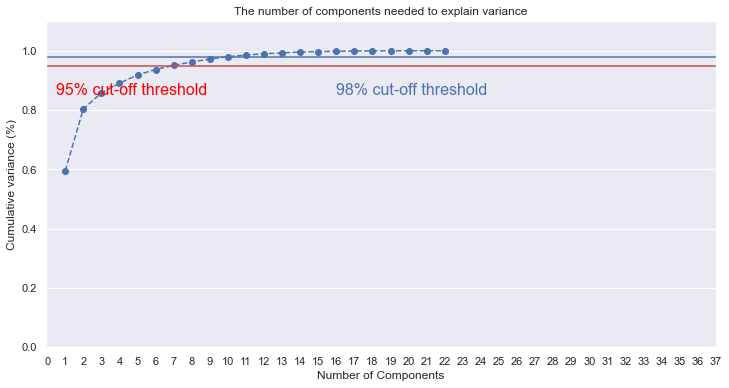

In [369]:
# Importing PCA (run this cell if needs be AFTER the next)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(subset_scaled_df)

pca = PCA().fit(data_rescaled)

# plot the %of variance captured in PCA components
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 23, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 38, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.axhline(y=0.98, color='b', linestyle='-')
plt.text(16, 0.85, '98% cut-off threshold', color = 'b', fontsize=16)

ax.grid(axis='x')
plt.show()

**from this plot we need 7 components to reach 95% data variability description
or 10 to reach 98%**

the dataset has suffered a lot of loss due to NaNs, So I will preserve 10 components 

**K-Means Clustering**

In [370]:
k_means_df = data_pca.copy()  # always copy :)))))
k_means_df

,0,1,2,3,4,5,6,7,8,9
0,1.487120,0.999379,0.893268,0.257199,0.174963,-0.237281,0.411273,-0.098981,0.011557,-0.011960
1,1.358969,0.716484,0.867867,0.260904,0.222838,-0.167778,0.504270,-0.082857,-0.118737,-0.027604
2,1.280417,0.520907,0.810007,0.193434,0.170509,-0.151701,0.373160,-0.046314,0.004724,-0.009482
3,1.357480,1.097159,0.800109,0.238946,0.202243,-0.248896,-0.148140,-0.115567,-0.204842,0.180028
4,1.286864,1.222809,0.713399,0.283864,0.231157,-0.141243,-0.206916,-0.117205,-0.129558,0.044001
...,...,...,...,...,...,...,...,...,...,...
15015,0.997328,-0.387317,-0.101202,-0.008370,-0.077598,0.082530,0.099591,-0.090086,-0.137017,-0.073656
15016,0.984070,-0.456938,-0.008887,0.052638,0.029541,0.062907,0.027111,-0.083502,-0.141291,-0.105091
15017,1.186756,-0.216089,0.055558,-0.023971,-0.059653,0.014261,0.000493,-0.058577,-0.027297,-0.076672
15018,1.118351,-0.457739,0.119023,-0.040096,-0.038575,0.011465,-0.063218,-0.015946,-0.002263,-0.022778


Number of Clusters: 1 	Average Distortion: 0.9741673124823084
Number of Clusters: 6 	Average Distortion: 0.47000243320687685
Number of Clusters: 11 	Average Distortion: 0.4050619208507689
Number of Clusters: 16 	Average Distortion: 0.37893021120181336
Number of Clusters: 21 	Average Distortion: 0.3510600837247932
Number of Clusters: 26 	Average Distortion: 0.3368432736799353
Number of Clusters: 31 	Average Distortion: 0.3196545237655538
Number of Clusters: 36 	Average Distortion: 0.31940320937329664
Number of Clusters: 41 	Average Distortion: 0.30623629420440246
Number of Clusters: 46 	Average Distortion: 0.30088026334703694
Number of Clusters: 51 	Average Distortion: 0.2991261153323034


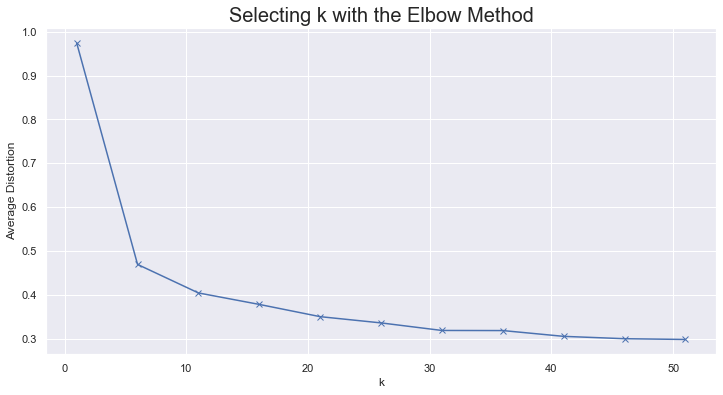

In [371]:
clusters = range(1,55,5)
meanDistortions = []

for k in clusters:
    model = KMedoids(n_clusters = k, random_state = 1)
    model.fit(k_means_df) #data_pca
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis = 1))
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize = 20)
# plt.savefig("kMeans_elbow_nocoords.png", facecolor = 'white')
plt.show()

## *both Kmeans and Kmedoids show a local elbow at @ 55 clusters.*

This is somewhat consistent with Mike Sonnewald result. Her DBScan method determined 115 provinces. Do we need that many?

**Observations:**

- there is no obvious flatenning of the graph, meaning if there are optimal number of clusters - it is not obvious. The **k-means method doesn't seem to produce any reasonable elbow**. 
Could be due to preprocessing
Could be due to the wrong choice of the method. 
**k-medids also method doesn't seem to produce any reasonable elbow**. 

**--->** Update, the slope appears much steeper with **Normalized** data

**I will move ahead with k = 7 (Expected to biomes)**. Anna has 13! We play with them later

**Obvious next steps:**
- get rid of well correlated variables (TK vs ROY) and see how biomes break. similar? different? 
- eliminte features one by one and see what happens
- change numbe rof biomes (k-means) 

In [372]:
kmeans = KMedoids(n_clusters = 13, random_state = 1)
kmeans.fit(k_means_df)

KMedoids(n_clusters=13, random_state=1)

It seems that with 13 biomes only there is no effect of PIC at all

trying to get it by Normailizing data

In [373]:
# df1 = df1.drop(["PIC*1000"], axis=1)

# Creating a copy of the original data. we attach biomes to the data with lon and Lat
df1 = df_PCA.copy()
# Adding K-Means cluster labels to the KMeans and original dataframes
k_means_df["Biomes"] = kmeans.labels_

df1["Biomes"] = kmeans.labels_
# df1["PIC*1000"] = 1000.*df1["PIC"]
df1.insert(21, "PIC*1000", 1000.*df1["PIC"])
df1 = df1.drop(["PIC"], axis=1)
df1.head()

,TK_T,TK_P,TK_N,TK_M,ROY_T,ROY_P,ROY_N,ROY_M,PAR,MLD,SST,Wind,U10,V10,Stram,Beh,CHL,PO4,Si,NO3,PIC*1000,Fe,Lon,Lat,Biomes
213,93.415760,20.627510,46.369711,26.418540,22.491640,7.373726,9.503942,5.613971,17.339264,133.519939,5.309917,8.533042,-0.373526,-0.661761,130.818425,24.514392,0.707617,1.688715,36.371675,17.706923,0.173796,0.162270,2,34,12
214,88.135992,19.890480,43.033768,25.211744,18.900750,6.043712,8.375642,4.481396,17.757064,149.333065,5.554833,8.609679,0.014558,-0.446003,121.186943,24.302691,0.541803,1.708275,37.560619,18.269347,0.086528,0.158520,2,35,12
215,81.319665,19.697681,39.407151,22.214832,16.094757,5.669616,6.078402,4.346739,18.309698,132.659894,5.372333,8.706004,0.301060,-0.240905,111.240647,23.730567,0.520367,1.701497,38.029529,18.454001,0.140325,0.167056,2,36,12
216,105.019851,20.559956,52.144119,32.315775,19.964172,6.566538,9.001948,4.395686,18.499598,33.754839,5.500403,8.775414,0.794858,-0.204257,134.763240,24.310856,0.596771,1.664337,37.360642,18.372599,0.091964,0.180131,2,37,12
219,105.001463,21.329952,50.595217,33.076293,21.075070,6.333699,9.033775,5.707596,19.916565,31.758396,6.322917,8.912842,2.171124,0.362151,129.218391,21.624637,0.708467,1.455113,27.758743,16.341985,0.121500,0.204469,2,40,12


### Cluster Profiles`

In [374]:
km_cluster_profile = round(df1.groupby("Biomes").mean(),3)

In [375]:
# Creating the "count_in_each_segment" feature in K-Means cluster profile

km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("Biomes")["Stram"].count().values
)

In [376]:
km_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,TK_T,TK_P,TK_N,TK_M,ROY_T,ROY_P,ROY_N,ROY_M,PAR,MLD,SST,Wind,U10,V10,Stram,Beh,CHL,PO4,Si,NO3,PIC*1000,Fe,Lon,Lat,count_in_each_segment
Biomes,,,,,,,,,,,,,,,,,,,,,,,,,
0,18.911000,13.140000,4.943000,0.828000,5.368000,3.766000,1.290000,0.312000,33.162000,35.972000,16.539000,7.707000,1.941000,-0.122000,39.274000,11.477000,0.109000,0.311000,1.964000,1.870000,0.057000,0.125000,67.495000,117.938000,596
1,37.010000,16.455000,15.367000,5.189000,8.873000,5.111000,2.797000,0.965000,45.816000,23.641000,27.830000,5.677000,-1.397000,0.540000,61.501000,9.733000,0.210000,0.168000,2.918000,0.308000,0.052000,0.302000,197.438000,85.810000,779
2,46.153000,20.080000,19.651000,6.422000,10.250000,6.597000,2.867000,0.785000,23.776000,58.453000,8.278000,10.363000,6.757000,-0.890000,64.587000,18.304000,0.227000,1.065000,5.643000,12.992000,0.132000,0.132000,192.952000,134.220000,1803
3,13.920000,10.794000,2.782000,0.344000,3.589000,2.565000,0.820000,0.205000,40.842000,32.055000,23.299000,6.608000,-2.703000,0.040000,29.863000,10.763000,0.072000,0.157000,1.789000,0.211000,0.056000,0.164000,106.715000,95.485000,1521
4,44.403000,18.999000,19.020000,6.384000,10.159000,6.109000,3.149000,0.901000,31.173000,42.321000,15.037000,8.292000,3.484000,0.339000,65.787000,16.160000,0.234000,0.406000,3.721000,2.341000,0.099000,0.129000,174.292000,105.284000,859
5,31.406000,15.630000,12.062000,3.714000,7.737000,4.828000,2.309000,0.601000,35.775000,30.624000,19.264000,7.334000,1.244000,0.614000,52.475000,11.644000,0.172000,0.192000,2.375000,0.573000,0.058000,0.175000,201.784000,92.291000,800
6,32.223000,17.503000,11.376000,3.344000,8.389000,5.003000,2.469000,0.918000,18.042000,84.342000,2.224000,10.309000,6.038000,-0.971000,58.727000,21.099000,0.200000,1.628000,22.440000,23.338000,0.147000,0.160000,182.259000,147.826000,2534
7,17.505000,12.292000,4.485000,0.729000,4.729000,3.301000,1.142000,0.287000,44.941000,27.070000,25.294000,6.824000,-4.872000,2.773000,36.082000,11.074000,0.096000,0.182000,2.443000,0.314000,0.054000,0.203000,219.237000,106.396000,1579
8,17.279000,12.107000,4.420000,0.752000,4.476000,3.120000,1.079000,0.276000,42.708000,28.930000,24.973000,6.458000,-3.217000,-1.633000,34.353000,10.113000,0.091000,0.119000,1.509000,0.251000,0.054000,0.282000,140.684000,78.419000,994


In [264]:
km_cluster_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TK_T                   13 non-null     float64
 1   TK_P                   13 non-null     float64
 2   TK_N                   13 non-null     float64
 3   TK_M                   13 non-null     float64
 4   ROY_T                  13 non-null     float64
 5   ROY_P                  13 non-null     float64
 6   ROY_N                  13 non-null     float64
 7   ROY_M                  13 non-null     float64
 8   PAR                    13 non-null     float64
 9   MLD                    13 non-null     float64
 10  SST                    13 non-null     float64
 11  Wind                   13 non-null     float64
 12  U10                    13 non-null     float64
 13  V10                    13 non-null     float64
 14  Stram                  13 non-null     float64
 15  Beh     

How to add coordinates back?
Shall we imply the biomes?  - yes  for supervised learning

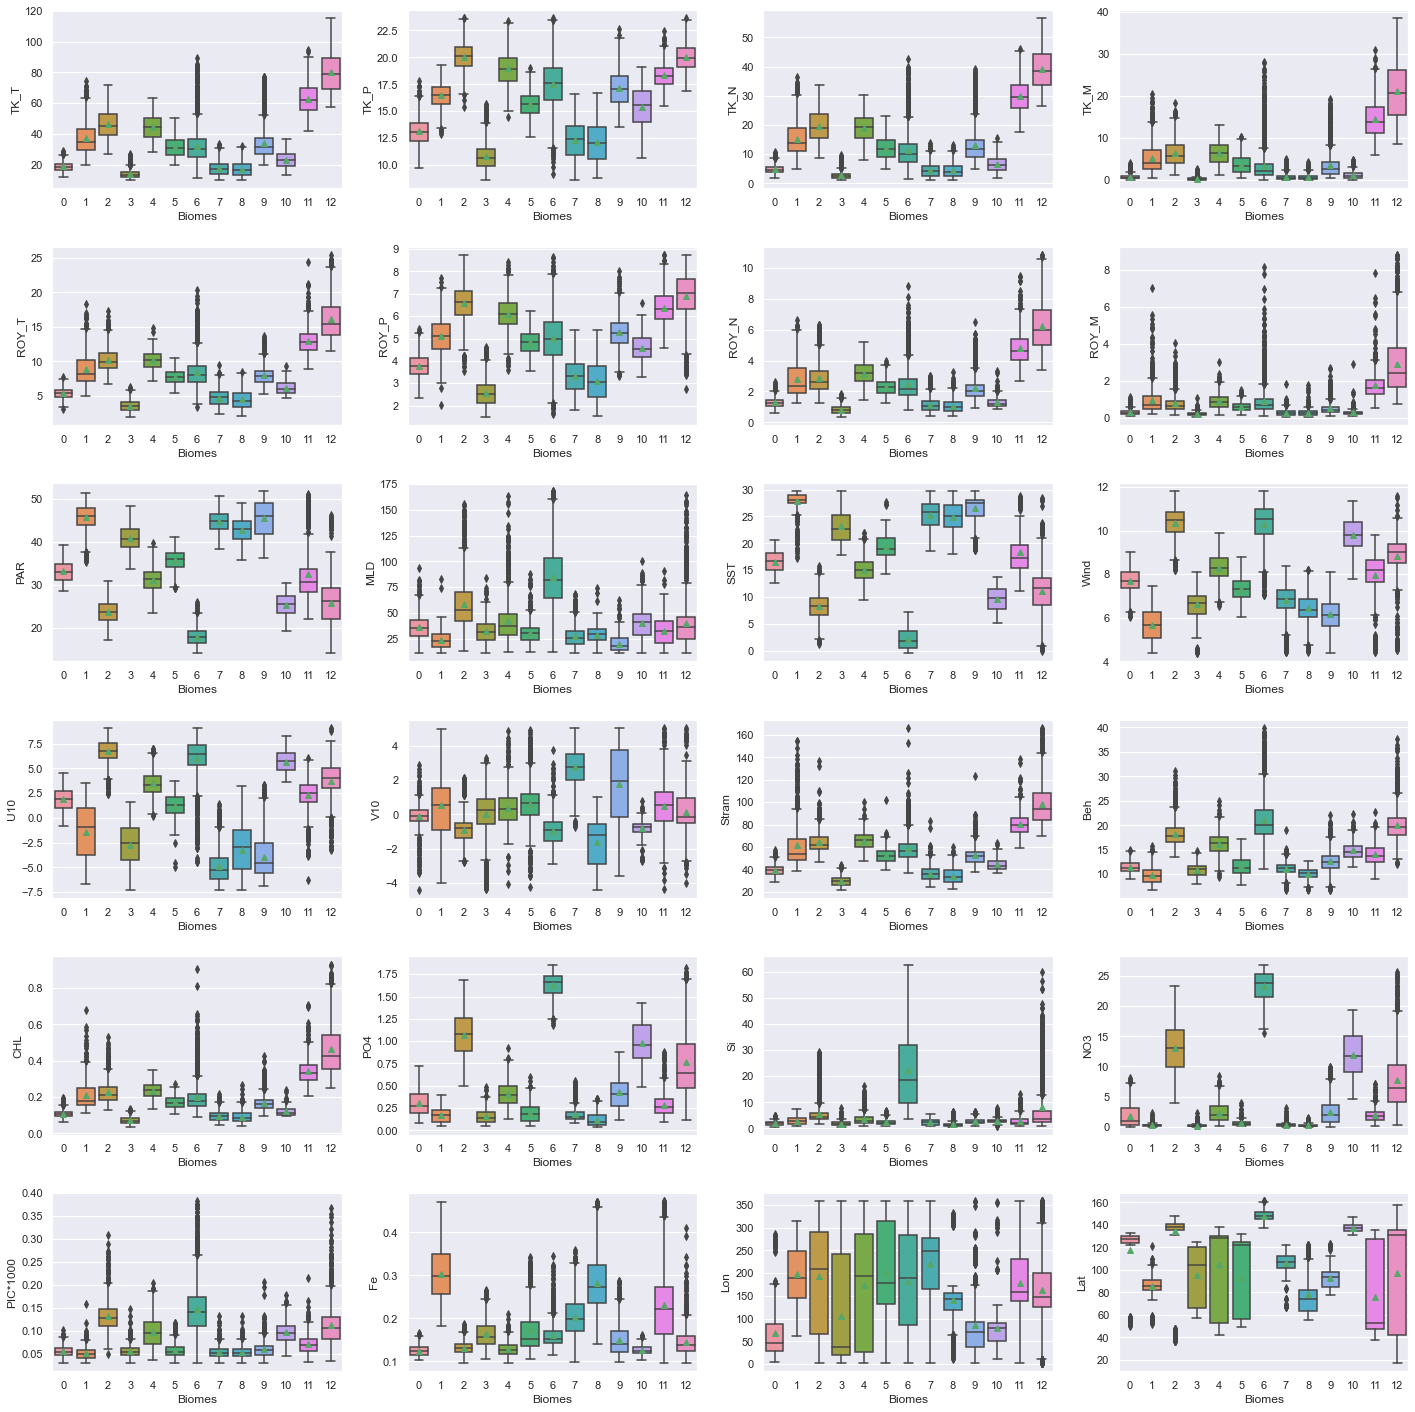

In [377]:
fig, axes = plt.subplots(6, 4, figsize = (20, 20))
sns.set(rc={'figure.figsize':(20,20),"font.size":7,"axes.titlesize":25,"axes.labelsize":25},style="white")
counter = 0
# sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15}) 
for ii in range(6):
    for jj in range(4):
        if counter < 24:
            sns.boxplot(
                ax = axes[ii][jj],
                data = df1,
                y = df1.columns[counter],
                x = "Biomes", showmeans = True,
                )
            counter = counter + 1
plt.savefig("kMedoids_yr_13clusters_coords_2023.png", facecolor = 'white')
fig.tight_layout(pad = 3.0)

So, where are these biomes? 

Cartpy and basemap do not work here (ask for packages in C++) They do not work in CoLAB either, But geopnadas do work. 

**Observations:**
Cluster1:


In [268]:
# import geopandas as gpd
# # import matplotlib.pyplot as plt
# # import pandas as pd

# from shapely.geometry import Point

# %matplotlib inline

In [385]:
# create lon/lat zip column

df2 = df1[["Biomes", "Lon", "Lat"]]

df2.to_csv('C:\\Users\\quinta\\AppData\\Roaming\\Python\\Python38\\Scripts\\Test_teaching\\Marine_data\\Biomass_study\\kmedoids_13_yr.csv') 
df2['Lon'] = (df2['Lon']-180)*-1
df2['Lat'] = (df2['Lat']-90)*-1

df2.head(10)

,Biomes,Lon,Lat
213,12,178,56
214,12,178,55
215,12,178,54
216,12,178,53
219,12,178,50
220,12,178,49
221,12,178,48
222,12,178,47
225,12,178,44
226,12,178,43


In [386]:
df2["Coords"] = list(zip(df1.Lon, df1.Lat))
df2.head()

,Biomes,Lon,Lat,Coords
213,12,178,56,"(2, 34)"
214,12,178,55,"(2, 35)"
215,12,178,54,"(2, 36)"
216,12,178,53,"(2, 37)"
219,12,178,50,"(2, 40)"


In [387]:
df2["Coords"] = df2["Coords"].apply(Point)
df2.head()

,Biomes,Lon,Lat,Coords
213,12,178,56,POINT (2 34)
214,12,178,55,POINT (2 35)
215,12,178,54,POINT (2 36)
216,12,178,53,POINT (2 37)
219,12,178,50,POINT (2 40)


In [388]:
gdf = gpd.GeoDataFrame(df2, geometry="Coords")
# gdf.head()

# Doesn't look different than a vanilla DataFrame...let's make sure we have what we want
print('gdf is of type:', type(gdf))

# And how can we tell which column is the geometry column?
print('\nThe geometry column is:', gdf.geometry.name)

gdf is of type: <class 'geopandas.geodataframe.GeoDataFrame'>

The geometry column is: Coords


In [389]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,889953.0,Oceania,Fiji,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,58005463.0,Africa,Tanzania,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,37589262.0,North America,Canada,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,328239523.0,North America,United States of America,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
# biom = fd2["Biomes"]

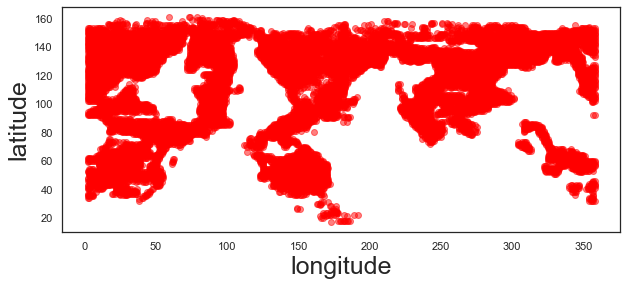

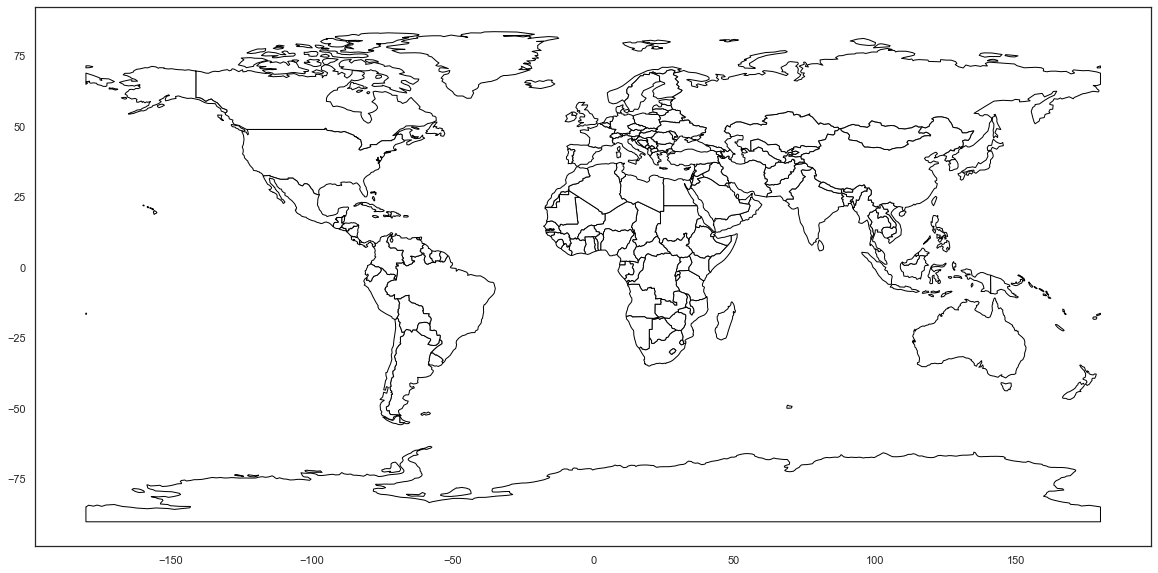

In [390]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
# world.plot(ax=gax, edgecolor='black',color='white')
base = world.plot(color='white', edgecolor='black')

# biomes.plot(ax=base, marker='o', color='red', markersize=5);
gdf.plot(ax=gax, color='red', alpha = 0.5)
# world.boundary.plot()

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(True)
gax.spines['right'].set_visible(True)

plt.show()

**TRYING DBSCAN**

In [86]:
from sklearn.cluster import DBSCAN
df_db = df1.copy()
df_db.head()
df_db = df_db.drop(['Biomes','Lat','Lon'], axis=1)
df_db.head()

,TK_T,TK_P,TK_N,TK_M,ROY_T,ROY_P,ROY_N,ROY_M,PAR,MLD,SST,Wind,U10,V10,tccurl,lpcurl,vecurl,PIC,Stram,Beh,CHL,PO4,Si,NO3,Fe,Month_v_Apr,Month_v_Aug,Month_v_Dec,Month_v_Feb,Month_v_Jan,Month_v_Jul,Month_v_Jun,Month_v_Mar,Month_v_May,Month_v_Nov,Month_v_Oct,Month_v_Sep
225,1.708600,1.118688,1.399838,1.109536,1.142152,0.914113,0.685439,-0.086106,0.968912,1.283374,0.799616,11.275903,4.706937,0.318891,0.015146,0.014050,0.013959,-4.838632,1.942999,1.036154,-0.471036,1.323958,1.264313,11.444828,-0.912201,0,0,0,0,1,0,0,0,0,0,0,0
226,1.777858,1.211736,1.479350,1.131043,1.176018,1.031504,0.555949,-0.188393,1.014571,1.323847,0.841422,11.526707,5.436304,0.346983,0.013539,0.012664,0.012571,-4.725852,1.900257,1.000478,-0.519590,1.153387,1.232119,9.997232,-0.924594,0,0,0,0,1,0,0,0,0,0,0,0
285,1.703755,1.133409,1.360488,1.146860,0.514426,0.412716,-0.277232,-0.811344,1.682019,1.283719,1.472230,5.724634,-3.506938,0.886475,-0.006151,-0.005775,-0.005288,-3.634513,1.485720,1.064708,-1.221975,0.224104,0.356020,0.391093,-0.719048,0,0,0,0,1,0,0,0,0,0,0,0
286,1.440334,1.167723,1.011260,0.412809,0.475667,0.224148,-0.092177,-0.296115,1.700821,1.274203,1.465219,5.961529,-3.968511,1.177341,-0.004456,-0.004511,-0.004138,-3.794256,1.500235,1.152919,-1.173917,0.233343,0.321000,0.385426,-0.701927,0,0,0,0,1,0,0,0,0,0,0,0
287,1.218866,1.086106,0.603581,-0.461312,0.525353,0.250510,0.104051,-0.521026,1.719755,1.262355,1.456412,6.075997,-4.286039,1.346720,-0.001567,-0.001591,-0.001483,-4.178273,1.502426,1.147978,-1.091213,0.231516,0.293866,0.401094,-0.681359,0,0,0,0,1,0,0,0,0,0,0,0


In [108]:
dbscan = DBSCAN(eps=5, min_samples = 20)
labels = dbscan.fit_predict(df1)

In [109]:
clust = np.unique(labels)
print(clust)

[-1  0  1  2  3  4  5  6  7  8]


**-1 is not a cluster - it is noise. If -1 is not present, that means the algorithm didn't detect noises**

In [115]:
mlbl = np.max(labels)
mlbl

8

In [90]:
# Adding DBSCAN cluster labels to the original dataframes
dbscan = dbscan.labels_
df1["Biomes"] = kmeans.labels_
df1.head()

TypeError: 'DBSCAN' object does not support item assignment

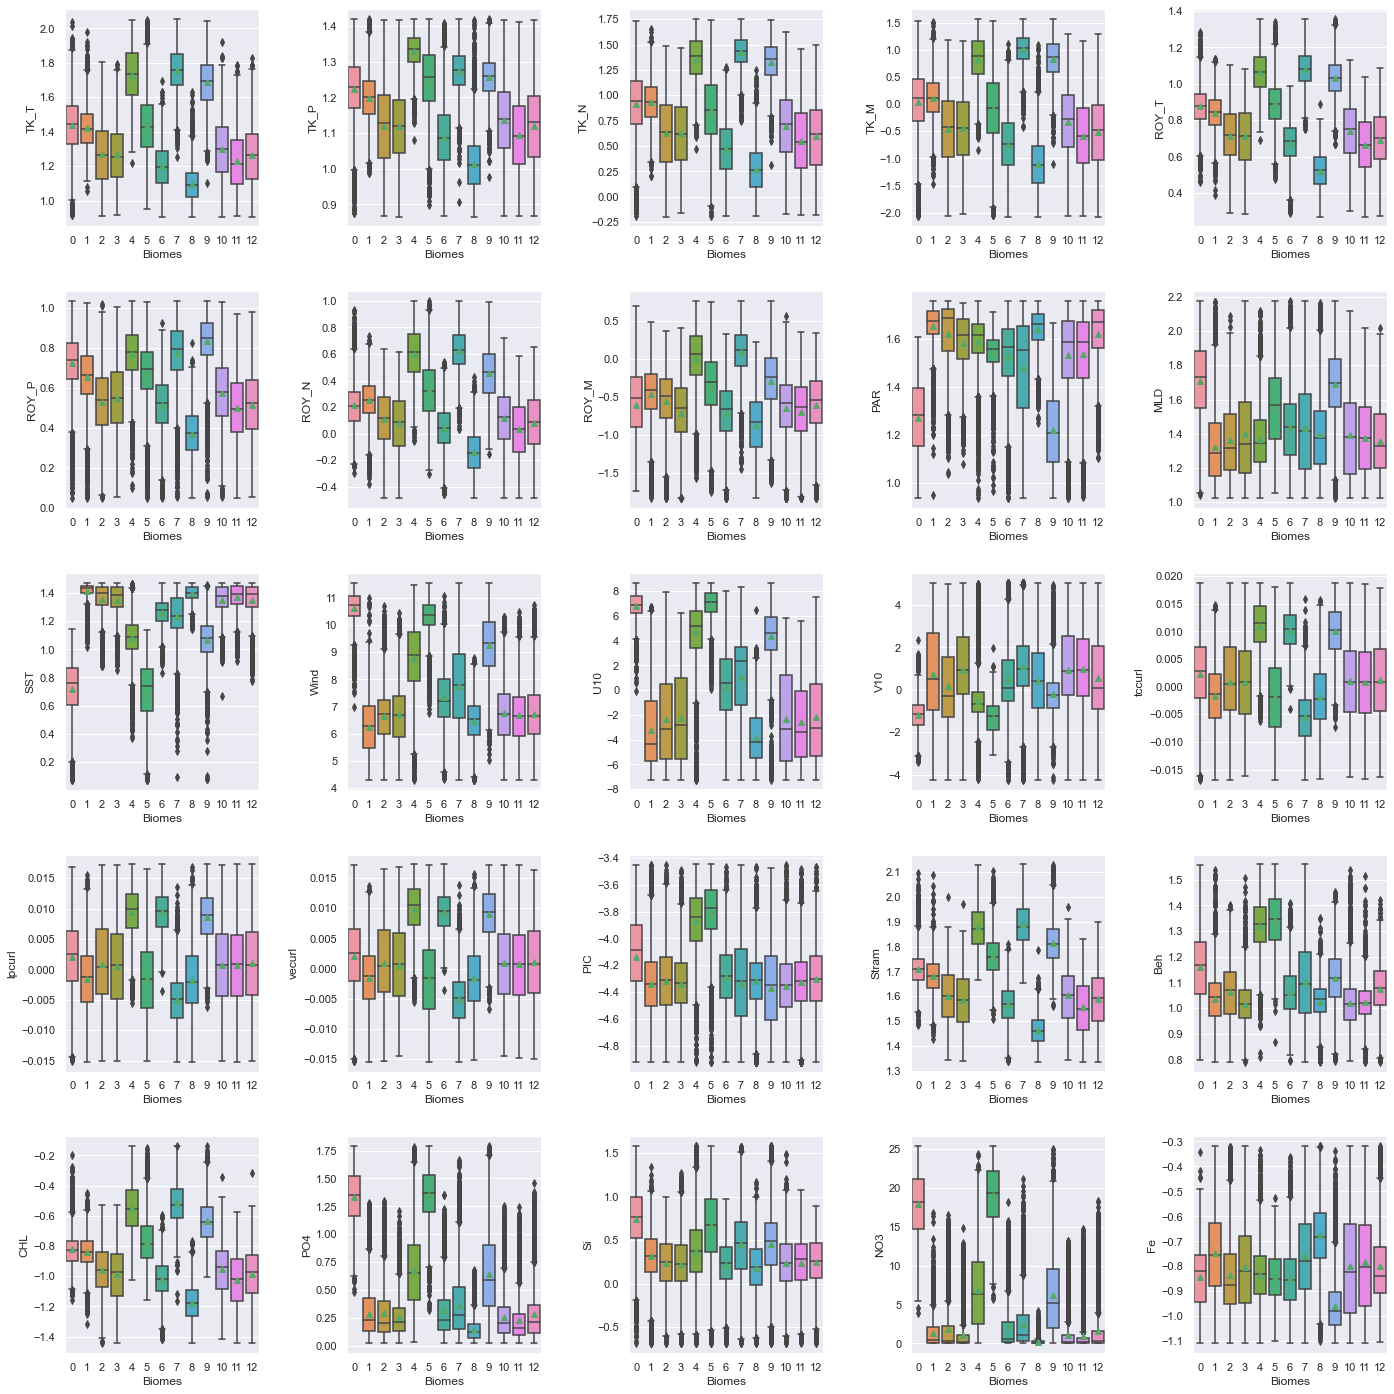

In [62]:
ccolors = ['black','blue','yellow','red','green','pink','brown','purple','silver','orange','beige','teal']

fig, axes = plt.subplots(5, 5, figsize = (20, 20))
counter = 0

for ii in range(5):
    for jj in range(5):
        if counter < 26:
            sns.boxplot(
                ax = axes[ii][jj],
                data = df1,
                y = df1.columns[counter],
                x = "Biomes", showmeans = True
            )
            counter = counter + 1
plt.savefig("dbscan_clusters_coords.png", facecolor = 'white')
fig.tight_layout(pad = 3.0)

# for i in clust:
#     plt.scatter(df1.iloc[labels == i,0], df[labels == i,1], s=10,c=ccolor[i])
#     plt.show